In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas_datareader as pdr
import seaborn as sns
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
warnings.filterwarnings('ignore')

/Users/gregoryrash/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Function to Validate Tickers
def validateTick(tick):
    
    # Try Inputting into Yahoo Stocks
    try:
        pdr.DataReader(f'{tick}','yahoo',date)
    
    # Raise Error if Invalid
    except:
        raise ValueError("Ticker Not Valid.")
        
# Function to Validate Date
def validate(date_text):
    
    # Try Check on Format
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# Function to Validate Date
def validateShift(shift):
    shift = int(shift)
    # Try Check on Format
    try:
        if 0 > shift <= 365:
            pass
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Please enter a whole number.")

In [3]:
# Pick a Start Date
date = input("Pick a start date for your analysis (YYYY-MM-DD): ")

# Validate Correct Date Format
validate(date)

# Pick a Stock
stock_selection = input("Pick a stock ticker for your analysis: ")

# Validate Correct Date Format
validateTick(stock_selection)

# Pick Shift
shift_selection = input("Pick how many days to shift your close values for your analysis: ")

# Validate Correct Date Format
validateShift(shift_selection)

Pick a start date for your analysis (YYYY-MM-DD):  2016-01-01
Pick a stock ticker for your analysis:  CME
Pick how many days to shift your close values for your analysis:  1


In [4]:
# Function to Create Stocks
def stockCreation(date, stock_selection, days_shifted):
    
    # Read Stock Data
    globals()[stock_selection] = pdr.DataReader(f'{stock_selection}','yahoo',date)
    
    # Create Shifted Close Column
    globals()[stock_selection]["Shifted Close"] = globals()[stock_selection]["Adj Close"].shift(-int(days_shifted))
    
    # Drop Rows Without Shift Values
    globals()[stock_selection].drop(globals()[stock_selection].tail(int(days_shifted)).index, inplace = True) 
    
    # Empty List to Hold Profit or Loss
    profit_loss = []
    
    # Iterate Through DataFrame
    for x in range(len(globals()[stock_selection])):
        
        # Handle Profitable Days
        if globals()[stock_selection]["Shifted Close"][x] > globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Profit" to Empty List
            profit_loss.append(1)
            
        # Handle Loss Days
        elif globals()[stock_selection]["Shifted Close"][x] < globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Loss" to Empty List
            profit_loss.append(-1)
            
        # Handle Push Days
        elif globals()[stock_selection]["Shifted Close"][x] == globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Push" to Empty List
            profit_loss.append(0)
    
    # Create Profit/Loss Column
    globals()[stock_selection]["Profit/Loss"] = profit_loss
    
    # Create Returns Column
    globals()[stock_selection]['Returns'] = np.log(globals()[stock_selection]['Adj Close'] / globals()[stock_selection]['Adj Close'].shift(1))
    
    # Iterate to Create STD Columns
    for x in range(5, 20, 5):
        
        # Create STD Column Based on Iteration
        col_name = 'std_' + str(x)
        
        # Add STD Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).std()

    # Iterate to Create MA Columns
    for x in range(10, 30, 5):
        
        # Create MA Column Based on Iteration
        col_name = 'ma_' + str(x)
        
        # Add MA Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).mean()

    # Iterate to Create % Change Columns
    for x in range(3, 12, 3):
        
        # Create % Change Column Based on Iteration
        col_name = 'pct_' + str(x)
        
        # Add % Change Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].pct_change().rolling(window=x).sum()

    # Create VMA 4 Column
    col_name = 'vma_4'
    
    # Add VMA 4 Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Volume'].rolling(4).mean()

    # Create Intraday Column
    col_name = 'co'
    
    # Add Intraday Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'] - globals()[stock_selection]['Open']
    
    # Drop All NaN's
    globals()[stock_selection].dropna(inplace=True)
    
    # Return DataFrame
    return globals()[stock_selection]

In [5]:
# Call Function
stockCreation(date, stock_selection, shift_selection)

,High,Low,Open,Close,Volume,Adj Close,Shifted Close,Profit/Loss,Returns,std_5,...,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,90.190002,2758100.0,75.330887,77.936836,1,0.018351,1.218740,...,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,93.309998,3233500.0,77.936836,75.614868,-1,0.034008,2.126921,...,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,90.529999,2133700.0,75.614868,74.604225,-1,-0.030246,2.154174,...,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,89.320000,1952800.0,74.604225,76.132721,1,-0.013456,1.512457,...,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,91.150002,1691200.0,76.132721,75.765213,-1,0.020281,1.253418,...,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,186.289993,179.690002,185.759995,182.710007,2515000.0,182.710007,184.369995,1,-0.013536,4.337415,...,4.799721,188.972002,186.876000,187.866500,190.168000,-0.047511,-0.048719,0.006921,2325175.0,-3.049988
2021-02-12,184.589996,182.110001,182.860001,184.369995,1441400.0,184.369995,189.410004,1,0.009044,4.345501,...,4.786531,189.235001,186.898000,187.378000,189.590400,-0.039625,-0.047655,-0.015357,2167750.0,1.509995
2021-02-16,189.899994,183.000000,185.089996,189.410004,2677700.0,189.410004,191.139999,1,0.026969,3.831152,...,4.773276,189.432001,187.234001,187.257500,189.179600,0.022977,-0.009261,-0.012401,2330600.0,4.320007


In [6]:
# Save Y Data
y = stockCreation(date, stock_selection, shift_selection)["Profit/Loss"]

# Save X Data
X = stockCreation(date, stock_selection, shift_selection).drop(["Shifted Close", "Profit/Loss"], axis=1)

In [7]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [8]:
# Create MinMaxScaler Model
X_scaler = MinMaxScaler().fit(X_train)

In [9]:
# Scale Training Data
X_train_scaled = X_scaler.transform(X_train)

# Scale Testing Data
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Initialize Gradient Boosting Classifer Model
GBC = GradientBoostingClassifier(random_state=1)

# Hyperparameters to Tune
parameters = {
    "n_estimators":list(range(1,100)),
    "max_features":["auto", "sqrt", "log2"],
    "max_depth":list(range(1,20)),
    "min_samples_split":list(range(1,20)),
    "min_samples_leaf":list(range(1,20)),
    "learning_rate":[.15, .1, .05, .01, .001],
    "random_state":[1]
}

# Hyperparameter Tune with RandomizedSearchCV
GBC_random = RandomizedSearchCV(estimator = GBC, param_distributions = parameters, cv = 5, n_iter = 500, verbose = 2, random_state = 1, n_jobs = -1)

# Fit Model
GBC_random.fit(X_train_scaled, y_train)

# Print Optimum Hyperparameters
print(GBC_random.best_params_)

In [10]:
# Create Model
model = GradientBoostingClassifier(n_estimators= 23, max_features="auto", max_depth = 3, min_samples_split = 6, min_samples_leaf = 7, learning_rate = .01, random_state=1)

# Fit Model
model.fit(X_train_scaled, y_train)

# Predict Train Data
y_pred_train = model.predict(X_train_scaled)

# Predict Test Data
y_pred = model.predict(X_test_scaled)

# Print Training Score
print("Model train accuracy:", accuracy_score(y_train, y_pred_train))

# Print Testing Score
print("Model test accuracy:", accuracy_score(y_test, y_pred))

Model train accuracy: 0.5515789473684211
Model test accuracy: 0.5899053627760252


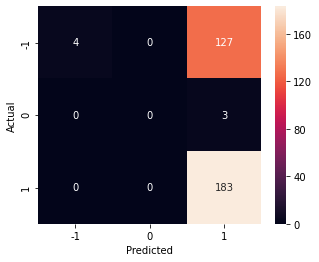

              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       131
           0       0.00      0.00      0.00         3
           1       0.58      1.00      0.74       183

    accuracy                           0.59       317
   macro avg       0.53      0.34      0.27       317
weighted avg       0.75      0.59      0.45       317



In [11]:
# Save Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create DataFrame
df = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", "1"])

# Plot Figure
plt.figure(figsize=(5,4))

# Add Heatmap Layer
sns.heatmap(df,annot=True, fmt='g')

# Plot X Labels
plt.xlabel("Predicted")

# Plot Y Labels
plt.ylabel("Actual")

# Show Plot
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred))